## Energy Forecasting with minimal data

This code is divided into three major components:
a. Data Exploration
b. Data Staging
c. Model Training and Performance analysis
d. Export flat file (csv) for UI

In [1]:
#Importing required libraries and packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import datetime as dt
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
# !pip install linearmodels

# Input Data Description

There are  three major components to the data:
a. Train Data: This contains the hourly level consumption data of ~600 buildings spanning across 28 days
b. Test Data: This data is obtained by splitting the consumption tain dataset containing ~150 buildings that have the first week of data, in order to predict the cold-start consumption
c. Meta Data: This contains attributes such as 'base-temperature', 'surface-area', 'days of week when the building isn't functioning' at a building id level.

In [2]:
# Importing the datasets

consumption = pd.read_csv('consumption_train.csv', index_col=0, parse_dates = ['timestamp'])# running on train dataset
df_meta = pd.read_csv('meta.csv')
consumption.describe()

,series_id,consumption,temperature
count,509376.000000,5.093760e+05,280687.000000
mean,101851.234828,1.076238e+05,15.188679
std,1020.487674,1.626611e+05,8.987142
min,100003.000000,0.000000e+00,-13.466667
25%,100998.000000,1.542092e+04,8.451190
50%,101884.500000,4.986205e+04,15.163333
75%,102697.000000,1.351661e+05,21.800000
max,103634.000000,2.085109e+06,44.350000


In [3]:
#creating a copy to ensure there is no loss of data
df = consumption.copy()

In [4]:
df.head()

,series_id,timestamp,consumption,temperature
Sl No,,,,
0,103088,2014-12-24 00:00:00,101842.23340,NaN
1,103088,2014-12-24 01:00:00,105878.04890,NaN
2,103088,2014-12-24 02:00:00,91619.10501,NaN
3,103088,2014-12-24 03:00:00,94473.70620,NaN
4,103088,2014-12-24 04:00:00,96976.75553,NaN


In [5]:
df_meta.head()

,series_id,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off
0,100003,x-large,low,False,False,False,False,False,True,True
1,100004,x-large,low,False,False,False,False,False,True,True
2,100006,x-small,low,False,False,False,False,False,True,True
3,100008,x-small,low,False,False,False,False,False,True,True
4,100010,x-small,low,False,False,False,False,False,True,True


### Data Exploration

In [6]:
# Removing temperature since more than 50% of data is missing
print((df['temperature'].isna().sum())/len(df))
df = df.drop(['temperature'], axis = 1)

0.4489591186078653


In [7]:
# Including the year, week, day of week and hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour
df['week'] = df['timestamp'].dt.week
df['year'] = df['timestamp'].dt.year


In [8]:
#Extracting relevant meta data, based on data exploration and pivoting the data
df_meta_days = df_meta.set_index('series_id').drop(['surface','base_temperature'], axis = 1)
df_meta_days.columns = [0,1,2,3,4,5,6]
df_workdays = df_meta_days.stack().reset_index()
df_meta_days.head()
df_workdays.columns = ['series_id','day_of_week','day_off']

In [9]:
# Merging the relevant metadata to the consumption data
df = pd.merge(df, df_workdays, how = 'left', left_on = ['series_id', 'day_of_week'], right_on = ['series_id', 'day_of_week'])
df.head()

,series_id,timestamp,consumption,day_of_week,hour,week,year,day_off
0,103088,2014-12-24 00:00:00,101842.23340,2,0,52,2014,False
1,103088,2014-12-24 01:00:00,105878.04890,2,1,52,2014,False
2,103088,2014-12-24 02:00:00,91619.10501,2,2,52,2014,False
3,103088,2014-12-24 03:00:00,94473.70620,2,3,52,2014,False
4,103088,2014-12-24 04:00:00,96976.75553,2,4,52,2014,False


In [10]:
# Identifying the average consumption of the building's by day of week, and pivoting the data by day_of_week
df_daily = pd.DataFrame(df.groupby(['series_id','day_of_week'])['consumption'].mean()).reset_index()
df_daily = df_daily.pivot(index = 'series_id', columns = 'day_of_week', values = ['consumption'])

In [11]:
#Normalizing across rows to stage the data for clustering

df_daily_norm = df_daily.div(df_daily.sum(axis = 1), axis = 0)
df_daily_norm.head()

consumption                                                    \
day_of_week           0         1         2         3         4         5   
series_id                                                                   
100003         0.146814  0.150058  0.148886  0.149828  0.148133  0.129318   
100006         0.144956  0.141678  0.139698  0.149681  0.153969  0.151258   
100008         0.144554  0.157239  0.139609  0.138358  0.141217  0.157827   
100017         0.149439  0.149846  0.149312  0.150003  0.146588  0.130997   
100021         0.140478  0.136342  0.149932  0.152784  0.155363  0.128690   

                       
day_of_week         6  
series_id              
100003       0.126963  
100006       0.118761  
100008       0.121197  
100017       0.123816  
100021       0.136411

In [12]:
# Running K-Means clustering of the dataset and using the Silhouette Score to identify that the best clustering happens at n_clusters=2
for i in range(2,11):
    model = KMeans(n_clusters = i, random_state = 101).fit(df_daily_norm)
    label = model.labels_
    sil = silhouette_score(df_daily_norm, label)
    print(f"For number of clusters={i}, The Silhouette Coefficient is {sil}")

For number of clusters=2, The Silhouette Coefficient is 0.4555946097237064
For number of clusters=3, The Silhouette Coefficient is 0.3814733644476161
For number of clusters=4, The Silhouette Coefficient is 0.41337016076982835
For number of clusters=5, The Silhouette Coefficient is 0.39275634088246797
For number of clusters=6, The Silhouette Coefficient is 0.30729080969088574
For number of clusters=7, The Silhouette Coefficient is 0.3756176775687794
For number of clusters=8, The Silhouette Coefficient is 0.3328126779743287
For number of clusters=9, The Silhouette Coefficient is 0.282792226007445
For number of clusters=10, The Silhouette Coefficient is 0.2892834969143522


In [13]:
# Assigning the clusters to each of the buildings
model = KMeans(n_clusters = 2,random_state=101).fit(df_daily_norm)
y_kmeans = model.predict(df_daily_norm)
y_means = list(y_kmeans)
df_daily_norm['cluster'] = y_means

In [14]:
# Summarizing the cluster counts
cluster_count_summary = df_daily_norm.groupby(['cluster'])['cluster'].count()
print(cluster_count_summary)       
    

cluster
0    451
1    307
Name: cluster, dtype: int64


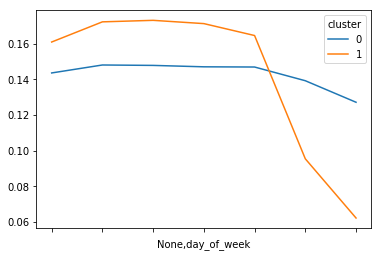

In [15]:
#Visualizing the behavior of each cluster

cluster_count_summary = df_daily_norm.groupby(['cluster']).mean()
cluster_count_summary.T.plot()

### Data Staging

In [16]:
df = df.drop(['timestamp'], axis = 1)
df_temp = df.reset_index()
df_temp = df_temp.groupby(['series_id','year', 'week', 'day_of_week']).sum()
df_temp = df_temp.drop(['index', 'hour','day_off'], axis = 1)
df_temp.head()

consumption
series_id year week day_of_week              
100003    2017 43   1            5.323794e+06
                    2            5.311667e+06
                    3            5.323794e+06
                    4            5.363207e+06
                    5            4.684090e+06

In [17]:
df_staged = pd.pivot_table(df_temp, index = ['series_id','year','week'], columns = ['day_of_week'],values = 'consumption')

In [18]:
df_staged.head()

day_of_week                     0             1             2             3  \
series_id year week                                                           
100003    2017 43             NaN  5.323794e+06  5.311667e+06  5.323794e+06   
               44    5.338953e+06  5.548145e+06  5.435970e+06  5.420811e+06   
               45    5.260127e+06  5.423843e+06  5.387461e+06  5.414747e+06   
               46    5.375334e+06  5.442033e+06  5.432938e+06  5.545114e+06   
               47    5.293476e+06           NaN           NaN           NaN   

day_of_week                     4             5             6  
series_id year week                                            
100003    2017 43    5.363207e+06  4.684090e+06  4.579494e+06  
               44    5.317731e+06  4.756853e+06  4.638613e+06  
               45    5.366239e+06  4.599200e+06  4.556756e+06  
               46    5.411716e+06  4.693185e+06  4.617391e+06  
               47             NaN           NaN           NaN

In [19]:
# removing all rows which contain NaNs
df_staged = df_staged.dropna()

In [20]:
#Train the model for the buildings belonging to cluster '1', i.e. the buildings that function for 7 days of the week 
df_daily_norm = df_daily_norm.reset_index()
cluster_0 = df_daily_norm['series_id'][df_daily_norm['cluster'] == 1]
df_0 = df_staged.reset_index()
df_0 = df_0[df_0['series_id'].isin(cluster_0)] 

In [21]:
#initializing a counter to give more information about number of weeks of data for a particular building

df_0['counter'] = 0
ct = np.zeros(df_0.shape[0]) # temp array for counter for no of weeks for a particular buidling
for i in range(1,df_0.shape[0]):
    if df_0['series_id'].iloc[i-1] == df_0['series_id'].iloc[i]:
        ct[i] = ct[i-1] + 1
    else:
        ct[i] = 0
        
df_0['counter'] = ct
df_0.head()

day_of_week,series_id,year,week,0,1,2,3,4,5,6,counter
17,100027,2017,30,2.135886e+05,2.031637e+05,1.883225e+05,1.929596e+05,2.030940e+05,2.053719e+05,2.044305e+04,0.0
18,100027,2017,31,2.234092e+05,2.421206e+05,2.236881e+05,2.314981e+05,2.486173e+05,2.153784e+05,2.081496e+04,1.0
19,100027,2017,32,2.599371e+05,2.614363e+05,2.396716e+05,2.405633e+05,2.510928e+05,2.179701e+05,2.064063e+04,2.0
29,100040,2017,46,1.012880e+07,1.961299e+07,2.410178e+07,2.510495e+07,2.250305e+07,4.544589e+06,4.704401e+06,0.0
30,100040,2017,47,9.141786e+06,1.789654e+07,2.205407e+07,2.198051e+07,1.755774e+07,4.284556e+06,4.545455e+06,1.0


In [22]:
#identifying those buildings for which we have two weeks of data, but not third week of data

ct1 = np.zeros(df_0.shape[0]) # second week yes, third week no
for i in range(1,df_0.shape[0]-1):
    if df_0['counter'].iloc[i] == 1 and df_0['counter'].iloc[i+1] == 0: #no data there for third week
        ct1[i] = 1
        ct1[i-1] = 1
df_0['no_third'] = ct1

df_no_third = pd.DataFrame(columns = df_0.columns)
df_no_third = df_no_third.append(df_0[df_0['no_third'] == 1], ignore_index = True)

df_0 = df_0[df_0['no_third'] == 0] # dropping those buildings who dont contain values for third week
df_0.head()

day_of_week,series_id,year,week,0,1,2,3,4,5,6,counter,no_third
17,100027,2017,30,2.135886e+05,2.031637e+05,1.883225e+05,1.929596e+05,2.030940e+05,2.053719e+05,2.044305e+04,0.0,0.0
18,100027,2017,31,2.234092e+05,2.421206e+05,2.236881e+05,2.314981e+05,2.486173e+05,2.153784e+05,2.081496e+04,1.0,0.0
19,100027,2017,32,2.599371e+05,2.614363e+05,2.396716e+05,2.405633e+05,2.510928e+05,2.179701e+05,2.064063e+04,2.0,0.0
29,100040,2017,46,1.012880e+07,1.961299e+07,2.410178e+07,2.510495e+07,2.250305e+07,4.544589e+06,4.704401e+06,0.0,0.0
30,100040,2017,47,9.141786e+06,1.789654e+07,2.205407e+07,2.198051e+07,1.755774e+07,4.284556e+06,4.545455e+06,1.0,0.0


In [23]:
#creating two categories of train data, depending on the consumption data availability over the weeks
df_train_1 = df_0[df_0['counter'] == 0 ] # this dataset contains data only for first week
df_train_2 = df_0[df_0['counter'] == 1] # dataset for second week

In [24]:
days_to_predict = ['y_monday', 'y_tuesday', 'y_wednesday', 'y_thursday', 'y_friday', 'y_saturday', 'y_sunday']
for i in range(len(days_to_predict)):
        df_train_1[days_to_predict[i]] = np.asarray(df_0[i][df_0['counter'] == 1])# appending labels for week 2 to data of week 1
        df_train_2[days_to_predict[i]] = np.asarray(df_0[i][df_0['counter'] == 2])# appending labels for week 3 to data of week 2

df_combine = pd.DataFrame(columns = ['series_id', 'year', 'week', 0, 1, 2, 3, 4, 5, 6, 'counter','no_third', 'y_monday', 'y_tuesday', 'y_wednesday',
       'y_thursday', 'y_friday', 'y_saturday', 'y_sunday'])
df_combine = df_combine.append(df_train_1, ignore_index = True)
df_combine = df_combine.append(df_train_2, ignore_index =True)
df_combine = df_combine.drop(['no_third'], axis = 1)  #dropping columns that 
df_train_2.head()        

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


day_of_week,series_id,year,week,0,1,2,3,4,5,6,counter,no_third,y_monday,y_tuesday,y_wednesday,y_thursday,y_friday,y_saturday,y_sunday
18,100027,2017,31,2.234092e+05,2.421206e+05,2.236881e+05,2.314981e+05,2.486173e+05,2.153784e+05,2.081496e+04,1.0,0.0,2.599371e+05,2.614363e+05,2.396716e+05,2.405633e+05,2.510928e+05,2.179701e+05,2.064063e+04
30,100040,2017,47,9.141786e+06,1.789654e+07,2.205407e+07,2.198051e+07,1.755774e+07,4.284556e+06,4.545455e+06,1.0,0.0,9.965927e+06,1.851240e+07,2.099266e+07,2.279996e+07,1.798809e+07,4.500479e+06,4.960266e+06
46,100053,2014,49,2.580721e+06,2.527722e+06,2.228609e+06,2.285569e+06,2.526073e+06,1.354144e+06,1.248819e+06,1.0,0.0,1.098561e+06,2.110248e+06,2.018555e+06,2.041319e+06,2.057817e+06,1.109283e+06,7.726233e+05
52,100064,2017,33,3.508516e+06,3.610174e+06,3.430317e+06,3.659700e+06,3.818704e+06,2.739562e+06,2.226057e+06,1.0,0.0,3.206147e+06,3.161835e+06,3.247853e+06,3.498089e+06,3.922969e+06,3.002831e+06,2.674396e+06
59,100085,2017,33,5.659770e+04,5.393810e+04,4.790533e+04,5.092172e+04,4.706204e+04,2.465000e+04,2.828263e+04,1.0,0.0,5.309481e+04,4.998112e+04,5.170014e+04,5.114876e+04,4.586198e+04,2.380671e+04,2.795829e+04


In [25]:
df_combine.columns = ['series_id', 'year', 'week','monday', 'tuesday', 'wednesday', 'thursday', 'friday',
       'saturday', 'sunday', 'counter', 'y_monday', 'y_tuesday', 'y_wednesday',
       'y_thursday', 'y_friday', 'y_saturday', 'y_sunday']
df_combine.columns

Index(['series_id', 'year', 'week', 'monday', 'tuesday', 'wednesday',
       'thursday', 'friday', 'saturday', 'sunday', 'counter', 'y_monday',
       'y_tuesday', 'y_wednesday', 'y_thursday', 'y_friday', 'y_saturday',
       'y_sunday'],
      dtype='object')

In [26]:
#Splitting df_train into training and test sets

df_train, df_test = train_test_split(df_combine, test_size=0.2, random_state = 5)
print(len(df_train), len(df_test))

480 120


In [27]:
df_arima = consumption.copy()
df_panelOLS = consumption.copy()

### Model training and performance analysis

#### Linear Model

In [28]:
from sklearn import linear_model
betas = [] # coeffs for prediction corresponding to the ith day
intercepts = [] #intercepts
train_scores = []# train scores for ith day
y_predict_1 = []
y_predict_2 = []
y_predict_3 = []
test_scores = []# test scores for ith day
from sklearn.metrics import mean_squared_error
for i in range(len(days_to_predict)):
    reg = linear_model.LinearRegression()
    soln = reg.fit(df_train[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']], df_train[days_to_predict[i]])
    betas.append(soln.coef_)
    intercepts.append(soln.intercept_)
    train_scores.append(soln.score(df_train[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']], df_train[days_to_predict[i]]))
    test_scores.append(soln.score(df_test[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']], df_test[days_to_predict[i]]))
    #mse = mean_squared_error(soln.predict(df_test[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']]), df_test[days_to_predict[i]])
    #print(mse)
    #break
print('Test accuracy for consumption prediction for each of the days is', test_scores) #shows the test scores for all the seven models that predict for each of the days

Test accuracy for consumption prediction for each of the days is [0.8787695097316557, 0.9785628683265383, 0.9831163961650613, 0.9823956218193151, 0.9536681193627521, 0.7867752948517845, 0.8054519987034406]


In [29]:
#Empirical expectation of accuracy across the models predicting the data for the seven days of the week
print('Overall accuracy:',(sum(test_scores)/len(test_scores)))

Overall accuracy: 0.9098199727086496


#### Polynomial Regression

In [30]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2, interaction_only = True)

In [31]:
from sklearn import linear_model
betas_2 = [] # coeffs for prediction corresponding to the ith day
intercepts_2 = [] #intercepts
train_scores_2 = []# train scores for ith day
test_scores_2 = []# test scores for ith day
for i in range(len(days_to_predict)):
    reg = linear_model.LinearRegression()
    soln = reg.fit(poly.fit_transform(df_train[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']]),
                   df_train[days_to_predict[i]])
    betas_2.append(soln.coef_)
    intercepts_2.append(soln.intercept_)
    train_scores_2.append(soln.score(poly.fit_transform(df_train[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']]),
                                     df_train[days_to_predict[i]]))
    test_scores_2.append(soln.score(poly.fit_transform(df_test[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']]),
                                    df_test[days_to_predict[i]]))

print('Test accuracy for consumption prediction for each of the days is', test_scores_2) #shows the test scores for all the seven models that predict for each of the days
print('Train accuracy for consumption prediction for each of the days is', train_scores_2) #shows the test scores for all the seven models that predict for each of the days


Test accuracy for consumption prediction for each of the days is [0.4077922132316692, 0.8766077271205142, 0.9396119613553084, 0.8370728226107804, 0.8468659980468509, -0.3348760627044267, 0.7012236880916348]
Train accuracy for consumption prediction for each of the days is [0.9423620324777784, 0.9728421106889772, 0.9792147300363963, 0.969775864588211, 0.9477447357936579, 0.878897533019006, 0.8217181431296118]


In [32]:
print('Overall accuracy:',(sum(test_scores_2)/len(test_scores_2)))

#The overall accuracy as well as low test score, despite high training score clearly suggests that the model overfits

Overall accuracy: 0.6106140496789044


#### Ridge Regression

In [33]:
betas_3 = [] # coeffs for prediction corresponding to the ith day
intercepts_3 = [] #intercepts
train_scores_3 = []# train scores for ith day
test_scores_3 = []# test scores for ith day
for i in range(len(days_to_predict)):
    reg = linear_model.Ridge(alpha = 1)
    soln = reg.fit(df_train[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']], df_train[days_to_predict[i]])
    #betas_3.append(soln.sparse_coef_)
    intercepts_3.append(soln.intercept_)
    train_scores_3.append(soln.score(df_train[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']], df_train[days_to_predict[i]]))
    test_scores_3.append(soln.score(df_test[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']], df_test[days_to_predict[i]]))


In [34]:

print('Test accuracy for consumption prediction for each of the days is', test_scores_3) #shows the test scores for all the seven models that predict for each of the days
print('Train accuracy for consumption prediction for each of the days is', train_scores_3) #shows the test scores for all the seven models that predict for each of the days


Test accuracy for consumption prediction for each of the days is [0.8787695097316565, 0.9785628683265374, 0.9831163961650622, 0.982395621819315, 0.9536681193627523, 0.7867752948517849, 0.8054519987034408]
Train accuracy for consumption prediction for each of the days is [0.9043582918838863, 0.9637644074009003, 0.9736728188147212, 0.9607897691312147, 0.8751056555229568, 0.7089294578897931, 0.7495578026529837]


In [35]:
print("Overall accuracy: ", sum(test_scores_3)/len(test_scores_3))
#mean(test_scores_3)

Overall accuracy:  0.9098199727086499


#### Lasso

In [36]:
betas_4 = [] # coeffs for prediction corresponding to the ith day
intercepts_4 = [] #intercepts
train_scores_4 = []# train scores for ith day
test_scores_4 = []# test scores for ith day
for i in range(len(days_to_predict)):
    reg = linear_model.Lasso(alpha = 1)
    soln = reg.fit(df_train[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']], df_train[days_to_predict[i]])
    #betas_3.append(soln.sparse_coef_)
    intercepts_4.append(soln.intercept_)
    train_scores_4.append(soln.score(df_train[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']], df_train[days_to_predict[i]]))
    test_scores_4.append(soln.score(df_test[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']], df_test[days_to_predict[i]]))


/srv/app/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [37]:
print('Test accuracy for consumption prediction for each of the days is', test_scores_4) #shows the test scores for all the seven models that predict for each of the days
print('Train accuracy for consumption prediction for each of the days is', train_scores_4) #shows the test scores for all the seven models that predict for each of the days


Test accuracy for consumption prediction for each of the days is [0.8787695134075012, 0.9785628682086241, 0.9831163958200647, 0.982395621542134, 0.9536681230761688, 0.7867752938217407, 0.8054519989422708]
Train accuracy for consumption prediction for each of the days is [0.9043582918838858, 0.9637644074009003, 0.973672818814721, 0.9607897691312147, 0.8751056555229564, 0.7089294578897931, 0.7495578026529834]


In [38]:
print("Overall accuracy: ",sum(test_scores_4)/len(test_scores_4))

Overall accuracy:  0.9098199735455006


#### Comparison Plots

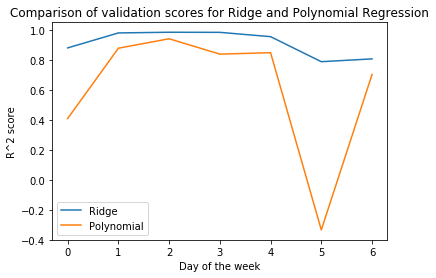

In [39]:
x = [i for i in range(7)] # x-axis is the number of days
plt.figure()
plt.title('Comparison of validation scores for Ridge and Polynomial Regression')
#plt.plot(x, test_scores, label = 'Linear')
plt.xlabel('Day of the week')
plt.ylabel('R^2 score')
plt.plot(x, test_scores_3, label = 'Ridge')
plt.plot(x, test_scores_2, label = 'Polynomial')
plt.legend()
plt.show() 

#### Random Forest by using  'GridSearchCV' package

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

estimator = RandomForestRegressor()

param_grid = { 
            "n_estimators"      : [10, 30, 50, 100],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            "max_depth": [5, 8, 10, 12]
            }

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

X_t = df_train[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']]
y_t = df_train[['y_monday', 'y_tuesday', 'y_wednesday','y_thursday', 'y_friday', 'y_saturday', 'y_sunday']]

grid.fit(X_t,df_train['y_monday'])

best_params = grid.best_params_

In [41]:
rf_train_scores = []# train scores for ith day
rf_test_scores = []# test scores for ith day

for i in range(len(days_to_predict)):
    random_forest = RandomForestRegressor(n_jobs=-1).set_params(**best_params)
    random_forest.fit(X_t, y_t[days_to_predict[i]])
    rf_train_scores.append(random_forest.score(X_t, y_t[days_to_predict[i]]))
    rf_test_scores.append(random_forest.score(df_test[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']], df_test[days_to_predict[i]]))

In [42]:
print('Test accuracy for consumption prediction for each of the days is', rf_test_scores) #shows the test scores for all the seven models that predict for each of the days
print('Train accuracy for consumption prediction for each of the days is', rf_train_scores) #shows the test scores for all the seven models that predict for each of the days
print("Overall accuracy: ",sum(rf_test_scores)/len(rf_test_scores))

Test accuracy for consumption prediction for each of the days is [0.8544082869160329, 0.971176003460495, 0.9771037614501734, 0.9777038651440481, 0.9251157427158826, 0.878711377185169, 0.8174179829712848]
Train accuracy for consumption prediction for each of the days is [0.9566127376126348, 0.9853040246297943, 0.98268262943777, 0.9773117876654411, 0.9486164849989265, 0.9148477934157745, 0.9359303446762537]
Overall accuracy:  0.9145195742632979


#### Neural nets

In [43]:
# Using keras
import keras.backend as K
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM


/srv/app/venv/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [44]:
feed_train = df_train[['monday','tuesday','wednesday','thursday','friday','saturday','sunday', 'y_monday']]
feed_test = df_test[['monday','tuesday','wednesday','thursday','friday','saturday','sunday', 'y_monday']]
feed_train = np.asarray(feed_train)
Y_train = feed_train[:,7]
train_temp = feed_train[:,0:7]

feed_test = np.asarray(feed_test)
Y_test = feed_test[:,7]
test_temp = feed_test[:,0:7]


In [45]:
# for lstm, shape needs to be samples, timesteps, features
X_train = np.reshape(train_temp, (train_temp.shape[0], train_temp.shape[1], 1))
X_test = np.reshape(test_temp, (test_temp.shape[0], test_temp.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(7, 1)))
model.add(Dense(1))
model.compile(loss='mean_absolute_error',  optimizer='adam')
model.fit(X_train, Y_train, epochs=50, batch_size=1, verbose=0)



In [46]:
Y_test = feed_test[:,7]
test_temp = feed_test[:,0:7]
X_test = np.reshape(test_temp, (test_temp.shape[0], test_temp.shape[1], 1))
preds = model.predict(X_test)
print(model.evaluate(X_test, Y_test))
# So lstm gives very poor results, it is not the right choice given the quantum of data

 32/120 [=======>......................] - ETA: 0s2375519.466666667


#### Panel OLS

In [48]:
!pip install linearmodels

  Using cached https://files.pythonhosted.org/packages/1e/a4/9e2c1e47d6876ecb40e341bfd8d04d02623a2e6a16a728b41b7ee6f45772/linearmodels-4.11-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3b/86/85c1be2e8db9e13ef9a350aecd6dea292bd612fa288c2f40d035bb750ded/cached_property-1.5.1-py2.py3-none-any.whl


In [49]:
from linearmodels import PanelOLS

df_panelOLS['date'] = [d.date() for d in df_panelOLS['timestamp']]
df_panelOLS1= pd.DataFrame(df_panelOLS.groupby(['series_id','date'])['consumption'].sum().reset_index())
df_panelOLS1_mean= pd.DataFrame(df_panelOLS1.groupby(['series_id'])['consumption'].sum().reset_index())

df_panelOLS3 = pd.merge(df_panelOLS1,df_panelOLS1_mean,how='left',left_on = 'series_id',right_on = 'series_id')
df_panelOLS3.columns = ['series_id','date','ind_consumption','avg_consumption']
df_panelOLS4 = df_panelOLS3.set_index(['series_id','date'])


md = PanelOLS(df_panelOLS4['ind_consumption'],df_panelOLS4[['avg_consumption']],time_effects = True)
res = md.fit(cov_type='clustered',cluster_entity=True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:        ind_consumption   R-squared:                        0.8703
Estimator:                   PanelOLS   R-squared (Between):              1.0000
No. Observations:               21224   R-squared (Within):             2.22e-16
Date:                Fri, Dec 07 2018   R-squared (Overall):              0.9049
Time:                        21:52:55   Log-likelihood                -3.282e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.311e+05
Entities:                         758   P-value                           0.0000
Avg Obs:                       28.000   Distribution:                 F(1,19540)
Min Obs:                       28.000                                           
Max Obs:                       28.000   F-statistic (robust):          1.311e+06
                            

#### AdaBoost Model

In [50]:
from sklearn.ensemble import AdaBoostRegressor
train_scores_ada = []# train scores for ith day
test_scores_ada = []# test scores for ith day
for i in range(len(days_to_predict)):
    ada = AdaBoostRegressor()
    soln = ada.fit(df_train[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']], df_train[days_to_predict[i]])
    train_scores_ada.append(soln.score(df_train[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']], df_train[days_to_predict[i]]))
    test_scores_ada.append(soln.score(df_test[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']], df_test[days_to_predict[i]]))
    

In [51]:
print('Test accuracy for consumption prediction for each of the days is', test_scores_ada) #shows the test scores for all the seven models that predict for each of the days
print('Train accuracy for consumption prediction for each of the days is', train_scores_ada) #shows the test scores for all the seven models that predict for each of the days

print("Overall accuracy: ",sum(test_scores_ada)/len(test_scores_ada))

Test accuracy for consumption prediction for each of the days is [0.7967950248238798, 0.9532419352651554, 0.9214789695389635, 0.9523383288332379, 0.91646225519467, 0.41108651770806187, 0.7680721416101977]
Train accuracy for consumption prediction for each of the days is [0.9275943733945691, 0.9717370294094249, 0.9592449431832765, 0.956800368878107, 0.9066578375867089, 0.9070878298532841, 0.9281431099750093]
Overall accuracy:  0.8170678818534522


#### ARIMA

In [59]:
from statsmodels.tsa.arima_model import ARIMA


df_arima['date'] = [d.date() for d in df_arima['timestamp']]

df_train_AR= pd.DataFrame(df_arima.groupby(['series_id','date'])['consumption'].sum().reset_index())
df_train_AR_1 = df_train_AR[df_train_AR['series_id']==103088].set_index(['date'])  #running the ARIMA model for one of the buildings - as a demo

# unique_series_id = df1['series_id'].unique()
# df1 = df[df['series_id'] == 103088]
# # drop_cols = ['Sl No','series_id','temperature']
# df1 = df1[['timestamp','consumption']].reset_index().set_index(df1['timestamp'])
# df11 = df1[['consumption']]
# df2.head()
# print(len(unique_series_id))

model = ARIMA(df_train_AR_1['consumption'],order=(2,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.consumption   No. Observations:                   27
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -414.884
Method:                       css-mle   S.D. of innovations        1130276.310
Date:                Fri, 07 Dec 2018   AIC                            839.769
Time:                        21:57:47   BIC                            846.248
Sample:                    12-25-2014   HQIC                           841.695
                         - 01-20-2015                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                6643.5491   2.11e+05      0.031      0.975   -4.07e+05    4.21e+05
ar.L1.D.consumption    -0.3950      0.307     -1.288      0.211      -0.996       0.206
ar.L2.D.consumpt

#### Plotting percentage wise importance of different days for predicting consumption for next Monday

[1734733.222573077, -213442.98968444017, 26752.63897813997, -1208337.3371753509, 2165458.0082230177, -383018.76015779446, 569461.1513326295]


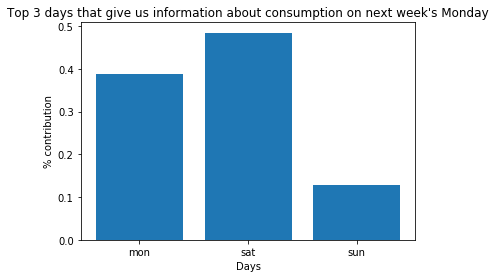

In [60]:
mean_consumption = []
days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
for i in days:
    mean_consumption.append(df_train[i].mean())
consumption_percent = []
for i in range(7):
    consumption_percent.append(mean_consumption[i] * betas[0][i])
print(consumption_percent)
cons_final = np.asarray(consumption_percent)
cons_final = cons_final[[0,4,6]] # only saturday, sunday, monday as they contain the highest positive values for beta
total = 0
for i in cons_final:
    total += i
cons_final = cons_final/total # to get percentage
# Using data from Linear regression
plt.figure()
plt.title("Top 3 days that give us information about consumption on next week's Monday")
plt.xlabel("Days")
plt.ylabel("% contribution")
plt.bar(['mon', 'sat', 'sun'], cons_final)
plt.show()

#### Using Recursive Feature Elimination

In [61]:
from sklearn.feature_selection import RFE

In [62]:

for i in range(7):
    reg = linear_model.LinearRegression()
    selector = RFE(reg, 3, step=1) # selecting 3 features (days), removing 1 at each iteration
    selector = selector.fit(df_train[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']], df_train[days_to_predict[i]])
    print(f'For {days[i]}, the best predictors are: ')
    for i in range(len(selector.ranking_)):
          if selector.ranking_[i] == 1:
                print(days[i])
          

For monday, the best predictors are: 
monday
friday
sunday
For tuesday, the best predictors are: 
tuesday
wednesday
sunday
For wednesday, the best predictors are: 
tuesday
wednesday
thursday
For thursday, the best predictors are: 
tuesday
wednesday
thursday
For friday, the best predictors are: 
wednesday
saturday
sunday
For saturday, the best predictors are: 
monday
wednesday
sunday
For sunday, the best predictors are: 
wednesday
friday
sunday


## Export flat-file for UI

In [63]:
#Performing sanity check on the first row to estimate

first_row = np.asarray(df_test[['monday','tuesday','wednesday','thursday','friday','saturday','sunday']].iloc[0])
first_row = first_row.reshape(1,7)

y_predict_1 = np.zeros((7))
for i in range(7):
    y_predict_1[i] = np.dot(first_row, betas[i])
y_predict_1 = y_predict_1.reshape(1,7)

y_predict_2 = np.zeros((7))
for i in range(7):
    y_predict_2[i] = np.dot(y_predict_1, betas[i])
y_predict_2 = y_predict_2.reshape(1,7)

y_predict_3 = np.zeros((7))
for i in range(7):
    y_predict_3[i] = np.dot(y_predict_2, betas[i])
y_predict_3 = y_predict_3.reshape(1,7)

for i in range(7):
    y_predict_1[:,i] += intercepts[i]
    y_predict_2[:,i] += intercepts[i]
    y_predict_3[:,i] += intercepts[i]

#Wrangling the data to make it ready for UI

y_predict = np.hstack((y_predict_1, y_predict_2, y_predict_3))
y_predict.reshape(21,1)

y_predict_df = pd.DataFrame(y_predict)
y_predict_df.to_csv('preds1.csv')